# Análisis de Hormonas Individuales

**Notebook:** Efectos aislados de cada hormona  
**Versión:** 1.0  
**Fecha:** Diciembre 2025

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nicolakorff/tfm-endocrine-llm/blob/main/examples/02_demo_isolared.ipynb)

---

Este notebook explora el **efecto aislado** de cada hormona para entender su función específica en la modulación del texto.

## Contenido

1. Dopamina (Exploración/Creatividad)
2. Cortisol (Cautela/Precisión)
3. Oxitocina (Empatía/Prosocialidad)
4. Adrenalina (Intensidad/Activación)
5. Serotonina (Estabilidad/Coherencia)
6. Comparación de Efectos
7. Análisis Cuantitativo

## 1. Instalación e imports

In [1]:
import torch
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer, LogitsProcessor, LogitsProcessorList
from dataclasses import dataclass, asdict
from typing import List, Dict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo de gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Instalación completada")

/Users/nicolakorff/tfm-endocrine-llm/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Instalación completada


## 2. Sistema Endocrino (Código Standalone)

In [2]:
@dataclass
class HormoneProfile:
    dopamine: float = 0.5
    cortisol: float = 0.5
    oxytocin: float = 0.5
    adrenaline: float = 0.5
    serotonin: float = 0.5

    def __post_init__(self):
        for field in ['dopamine', 'cortisol', 'oxytocin', 'adrenaline', 'serotonin']:
            value = getattr(self, field)
            if not 0 <= value <= 1:
                raise ValueError(f"{field} debe estar en [0,1]")

    def to_dict(self):
        return asdict(self)

    def __repr__(self):
        return (f"H[d={self.dopamine:.2f}, c={self.cortisol:.2f}, "
                f"o={self.oxytocin:.2f}, a={self.adrenaline:.2f}, s={self.serotonin:.2f}]")

class HormonalLogitsProcessor(LogitsProcessor):
    def __init__(self, hormone_profile: HormoneProfile):
        self.H = hormone_profile

    def __call__(self, input_ids, scores):
        # Temperatura (dopamina + cortisol)
        temp = 0.7 + 0.6 * self.H.dopamine - 0.4 * self.H.cortisol
        temp = max(0.3, min(temp, 1.5))
        scores = scores / temp

        # Top-k (cortisol)
        k = int(50 + 150 * (1 - self.H.cortisol))
        if k < scores.shape[-1]:
            top_k_scores, _ = torch.topk(scores, k)
            threshold = top_k_scores[..., -1, None]
            scores = torch.where(scores < threshold, -float('inf'), scores)

        return scores

class EndocrineModulatedLLM:
    def __init__(self, model_name="distilgpt2"):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Cargando {model_name} en {self.device}...")

        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForCausalLM.from_pretrained(model_name).to(self.device)

        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

        print("Modelo cargado")

    def generate_with_hormones(self, prompt, hormone_profile, max_new_tokens=50, num_return_sequences=1):
        processor = HormonalLogitsProcessor(hormone_profile)
        logits_processor = LogitsProcessorList([processor])

        inputs = self.tokenizer(prompt, return_tensors="pt").to(self.device)

        outputs = self.model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            num_return_sequences=num_return_sequences,
            do_sample=True,
            logits_processor=logits_processor,
            pad_token_id=self.tokenizer.eos_token_id
        )

        return [self.tokenizer.decode(out, skip_special_tokens=True) for out in outputs]

class TextMetrics:
    @staticmethod
    def compute_distinct_n(text, n=2):
        tokens = text.lower().split()
        if len(tokens) < n:
            return 0.0
        ngrams = [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
        return len(set(ngrams)) / len(ngrams) if ngrams else 0.0

    @staticmethod
    def compute_all(text):
        from textblob import TextBlob
        tokens = text.split()
        blob = TextBlob(text)

        return {
            'length': len(tokens),
            'distinct_1': TextMetrics.compute_distinct_n(text, 1),
            'distinct_2': TextMetrics.compute_distinct_n(text, 2),
            'sentiment': blob.sentiment.polarity
        }

print("Sistema endocrino definido")

Sistema endocrino definido


In [3]:
# Inicializar modelo
model = EndocrineModulatedLLM("distilgpt2")

Cargando distilgpt2 en cpu...
Modelo cargado


## 3. Análisis de Hormonas Individuales

Ahora vamos a explorar cada hormona de forma **aislada** para entender su efecto específico.

### 3.1. Dopamina: Exploración y Creatividad

#### Función Biológica
- **Recompensa y motivación**
- **Búsqueda de novedad**
- **Asunción de riesgos**

#### Implementación Computacional
- **Alta dopamina (0.9):** ↑ Temperatura, tokens menos probables
- **Baja dopamina (0.1):** ↓ Temperatura, tokens más seguros

#### Hipótesis
- Alta dopamina → Mayor diversidad léxica
- Alta dopamina → Menor coherencia (más riesgo)

In [7]:
print("="*80)
print("EXPERIMENTO 1: DOPAMINA (Exploración/Creatividad)")
print("="*80)

prompt = "The key to innovation is"

# Niveles de dopamina
dopamine_levels = [
    (0.1, "Muy Baja"),
    (0.5, "Baseline"),
    (0.9, "Muy Alta")
]

print(f"\nPrompt: {prompt}\n")

dopamine_results = []

for dopa_val, label in dopamine_levels:
    profile = HormoneProfile(
        dopamine=dopa_val,
        cortisol=0.5,
        oxytocin=0.5,
        adrenaline=0.5,
        serotonin=0.5
    )

    texts = model.generate_with_hormones(
        prompt,
        profile,
        max_new_tokens=40,
        num_return_sequences=1
    )

    metrics = TextMetrics.compute_all(texts[0])

    print(f"[DOPAMINA = {dopa_val:.1f} - {label}]")
    print(f"{texts[0]}")
    print(f"\nMétricas:")
    print(f"Diversidad (distinct-2): {metrics['distinct_2']:.3f}")
    print(f"Longitud: {metrics['length']} tokens")
    print("-"*80 + "\n")

    dopamine_results.append({
        'hormone': 'Dopamina',
        'level': dopa_val,
        'label': label,
        'text': texts[0],
        **metrics
    })

EXPERIMENTO 1: DOPAMINA (Exploración/Creatividad)

Prompt: The key to innovation is

[DOPAMINA = 0.1 - Muy Baja]
The key to innovation is the ability to take advantage of the growing market that has become the driving force behind the current generation of digital services.”
















Métricas:
Diversidad (distinct-2): 1.000
Longitud: 27 tokens
--------------------------------------------------------------------------------

[DOPAMINA = 0.5 - Baseline]
The key to innovation is to create better solutions – not only for companies but also for people – for working people."

Métricas:
Diversidad (distinct-2): 1.000
Longitud: 22 tokens
--------------------------------------------------------------------------------

[DOPAMINA = 0.9 - Muy Alta]
The key to innovation is to grow the economy. And I‼️‡️ — Senator Bernie Sanders (@SenSanders) June 24, 2016
















Métricas:
Diversidad (distinct-2): 1.000
Longitud: 19 tokens
-----------------------------------------------------------

### 3.2. Cortisol: Cautela y Precisión

#### Función Biológica
- **Respuesta al estrés**
- **Hipervigilancia**
- **Evitación de riesgos**

#### Implementación Computacional
- **Alto cortisol (0.9):** ↓ Top-k (solo tokens muy probables)
- **Bajo cortisol (0.1):** ↑ Top-k (permite más variación)

#### Hipótesis
- Alto cortisol → Menor diversidad
- Alto cortisol → Mayor coherencia (menos errores)

In [9]:
print("="*80)
print("EXPERIMENTO 2: CORTISOL (Cautela/Precisión)")
print("="*80)

prompt = "When making important decisions, one should"

cortisol_levels = [
    (0.1, "Muy Bajo (Relajado)"),
    (0.5, "Baseline"),
    (0.9, "Muy Alto (Estresado)")
]

print(f"\nPrompt: {prompt}\n")

cortisol_results = []

for cort_val, label in cortisol_levels:
    profile = HormoneProfile(
        dopamine=0.5,
        cortisol=cort_val,
        oxytocin=0.5,
        adrenaline=0.5,
        serotonin=0.5
    )

    texts = model.generate_with_hormones(
        prompt,
        profile,
        max_new_tokens=40,
        num_return_sequences=1
    )

    metrics = TextMetrics.compute_all(texts[0])

    print(f"[CORTISOL = {cort_val:.1f} - {label}]")
    print(f"{texts[0]}")
    print(f"\nMétricas:")
    print(f"Diversidad (distinct-2): {metrics['distinct_2']:.3f}")
    print(f"Longitud: {metrics['length']} tokens")
    print("-"*80 + "\n")

    cortisol_results.append({
        'hormone': 'Cortisol',
        'level': cort_val,
        'label': label,
        'text': texts[0],
        **metrics
    })

EXPERIMENTO 2: CORTISOL (Cautela/Precisión)

Prompt: When making important decisions, one should

[CORTISOL = 0.1 - Muy Bajo (Relajado)]
When making important decisions, one should not simply set out on the path of failure. Instead, one should build on a successful process by following the guidelines set out in A Roadmap for Responsive Thinking. In other words, a failure

Métricas:
Diversidad (distinct-2): 0.949
Longitud: 40 tokens
--------------------------------------------------------------------------------

[CORTISOL = 0.5 - Baseline]
When making important decisions, one should act on your own rather than on a team that is trying to convince you that you don't have to make a lot of decisions. While it may seem a small thing, it's certainly something you

Métricas:
Diversidad (distinct-2): 1.000
Longitud: 42 tokens
--------------------------------------------------------------------------------

[CORTISOL = 0.9 - Muy Alto (Estresado)]
When making important decisions, one should fee

### 3.3. Oxitocina: Empatía y Prosocialidad

#### Función Biológica
- **Vinculación social**
- **Empatía y compasión**
- **Comportamiento prosocial**

#### Implementación Computacional
- **Alta oxitocina (0.9):** ↑ Boost a palabras empáticas
- **Baja oxitocina (0.1):** Sin sesgo emocional

#### Hipótesis
- Alta oxitocina → Más palabras empáticas
- Alta oxitocina → Sentimiento más positivo

In [10]:
print("="*80)
print("EXPERIMENTO 3: OXITOCINA (Empatía/Prosocialidad)")
print("="*80)

prompt = "When someone is struggling, I try to"

oxytocin_levels = [
    (0.1, "Muy Baja (Distante)"),
    (0.5, "Baseline"),
    (0.9, "Muy Alta (Empática)")
]

print(f"\nPrompt: {prompt}\n")

oxytocin_results = []

for oxy_val, label in oxytocin_levels:
    profile = HormoneProfile(
        dopamine=0.5,
        cortisol=0.5,
        oxytocin=oxy_val,
        adrenaline=0.5,
        serotonin=0.5
    )

    texts = model.generate_with_hormones(
        prompt,
        profile,
        max_new_tokens=40,
        num_return_sequences=1
    )

    metrics = TextMetrics.compute_all(texts[0])

    print(f"[OXITOCINA = {oxy_val:.1f} - {label}]")
    print(f"{texts[0]}")
    print(f"\nMétricas:")
    print(f"   Sentimiento: {metrics['sentiment']:.3f}")
    print(f"   Diversidad (distinct-2): {metrics['distinct_2']:.3f}")
    print("-"*80 + "\n")

    oxytocin_results.append({
        'hormone': 'Oxitocina',
        'level': oxy_val,
        'label': label,
        'text': texts[0],
        **metrics
    })

EXPERIMENTO 3: OXITOCINA (Empatía/Prosocialidad)

Prompt: When someone is struggling, I try to

[OXITOCINA = 0.1 - Muy Baja (Distante)]
When someone is struggling, I try to look at how things get better. I try to look at things that I can't even see. I try to look at things that I can't even see...and then again, this is a

Métricas:
   Sentimiento: 0.500
   Diversidad (distinct-2): 0.667
--------------------------------------------------------------------------------

[OXITOCINA = 0.5 - Baseline]
When someone is struggling, I try to help them and when I try to help them, I try to find and help them find something to do. When I get my own, I try to help them. If they don't find something

Métricas:
   Sentimiento: 0.600
   Diversidad (distinct-2): 0.732
--------------------------------------------------------------------------------

[OXITOCINA = 0.9 - Muy Alta (Empática)]
When someone is struggling, I try to be patient and help them, as if they're not on board yet. But you also get to

### 3.4. Adrenalina: Intensidad y Activación

#### Función Biológica
- **Respuesta de lucha o huida**
- **Activación energética**
- **Foco intenso**

#### Implementación Computacional
- **Alta adrenalina (0.9):** Textos más concisos
- **Baja adrenalina (0.1):** Textos más elaborados

#### Hipótesis
- Alta adrenalina → Menor longitud
- Alta adrenalina → Más directo al punto

In [11]:
print("="*80)
print("EXPERIMENTO 4: ADRENALINA (Intensidad/Activación)")
print("="*80)

prompt = "In emergency situations, you must"

adrenaline_levels = [
    (0.1, "Muy Baja (Calmado)"),
    (0.5, "Baseline"),
    (0.9, "Muy Alta (Activado)")
]

print(f"\nPrompt: {prompt}\n")

adrenaline_results = []

for adr_val, label in adrenaline_levels:
    profile = HormoneProfile(
        dopamine=0.5,
        cortisol=0.5,
        oxytocin=0.5,
        adrenaline=adr_val,
        serotonin=0.5
    )

    texts = model.generate_with_hormones(
        prompt,
        profile,
        max_new_tokens=40,
        num_return_sequences=1
    )

    metrics = TextMetrics.compute_all(texts[0])

    print(f"[ADRENALINA = {adr_val:.1f} - {label}]")
    print(f"{texts[0]}")
    print(f"\nMétricas:")
    print(f"Longitud: {metrics['length']} tokens")
    print(f"Diversidad (distinct-2): {metrics['distinct_2']:.3f}")
    print("-"*80 + "\n")

    adrenaline_results.append({
        'hormone': 'Adrenalina',
        'level': adr_val,
        'label': label,
        'text': texts[0],
        **metrics
    })

EXPERIMENTO 4: ADRENALINA (Intensidad/Activación)

Prompt: In emergency situations, you must

[ADRENALINA = 0.1 - Muy Baja (Calmado)]
In emergency situations, you must take all necessary precautions to protect yourself and in case a person is threatened. We also advise people to not place undue stress on their bodies or in any situation or experience.


Tear Down

Métricas:
Longitud: 39 tokens
Diversidad (distinct-2): 1.000
--------------------------------------------------------------------------------

[ADRENALINA = 0.5 - Baseline]
In emergency situations, you must do your best to control where you need to go, and you don't need to worry about the impact that you will have on you. If you have a car or that's not available, the

Métricas:
Longitud: 40 tokens
Diversidad (distinct-2): 0.974
--------------------------------------------------------------------------------

[ADRENALINA = 0.9 - Muy Alta (Activado)]
In emergency situations, you must be aware of your surroundings and be prepa

### 3.5. Serotonina: Estabilidad y Coherencia

#### Función Biológica
- **Regulación del ánimo**
- **Estabilidad emocional**
- **Comportamiento consistente**

#### Implementación Computacional
- **Alta serotonina (0.9):** Penaliza repeticiones
- **Baja serotonina (0.1):** Permite más repetición

#### Hipótesis
- Alta serotonina → Sin repeticiones
- Alta serotonina → Más estable y coherente

In [12]:
print("="*80)
print("EXPERIMENTO 5: SEROTONINA (Estabilidad/Coherencia)")
print("="*80)

prompt = "The most important thing to remember is that"

serotonin_levels = [
    (0.1, "Muy Baja (Inestable)"),
    (0.5, "Baseline"),
    (0.9, "Muy Alta (Estable)")
]

print(f"\nPrompt: {prompt}\n")

serotonin_results = []

for ser_val, label in serotonin_levels:
    profile = HormoneProfile(
        dopamine=0.5,
        cortisol=0.5,
        oxytocin=0.5,
        adrenaline=0.5,
        serotonin=ser_val
    )

    texts = model.generate_with_hormones(
        prompt,
        profile,
        max_new_tokens=40,
        num_return_sequences=1
    )

    metrics = TextMetrics.compute_all(texts[0])

    print(f"[SEROTONINA = {ser_val:.1f} - {label}]")
    print(f"{texts[0]}")
    print(f"\nMétricas:")
    print(f"Diversidad (distinct-2): {metrics['distinct_2']:.3f}")
    print(f"Diversidad (distinct-1): {metrics['distinct_1']:.3f}")
    print("-"*80 + "\n")

    serotonin_results.append({
        'hormone': 'Serotonin',
        'level': ser_val,
        'label': label,
        'text': texts[0],
        **metrics
    })

EXPERIMENTO 5: SEROTONINA (Estabilidad/Coherencia)

Prompt: The most important thing to remember is that

[SEROTONINA = 0.1 - Muy Baja (Inestable)]
The most important thing to remember is that the most important thing to remember is that the most important thing to remember is that the most important thing to remember is that the most important thing to remember is that the most important thing to remember is that

Métricas:
Diversidad (distinct-2): 0.170
Diversidad (distinct-1): 0.167
--------------------------------------------------------------------------------

[SEROTONINA = 0.5 - Baseline]
The most important thing to remember is that if you are the owner of a company that has a product that is good for you, you are a person living in a building that has a product that's good for you, that's going to

Métricas:
Diversidad (distinct-2): 0.860
Diversidad (distinct-1): 0.591
--------------------------------------------------------------------------------

[SEROTONINA = 0.9 - Muy Alta

## 4. Comparación Visual de Efectos

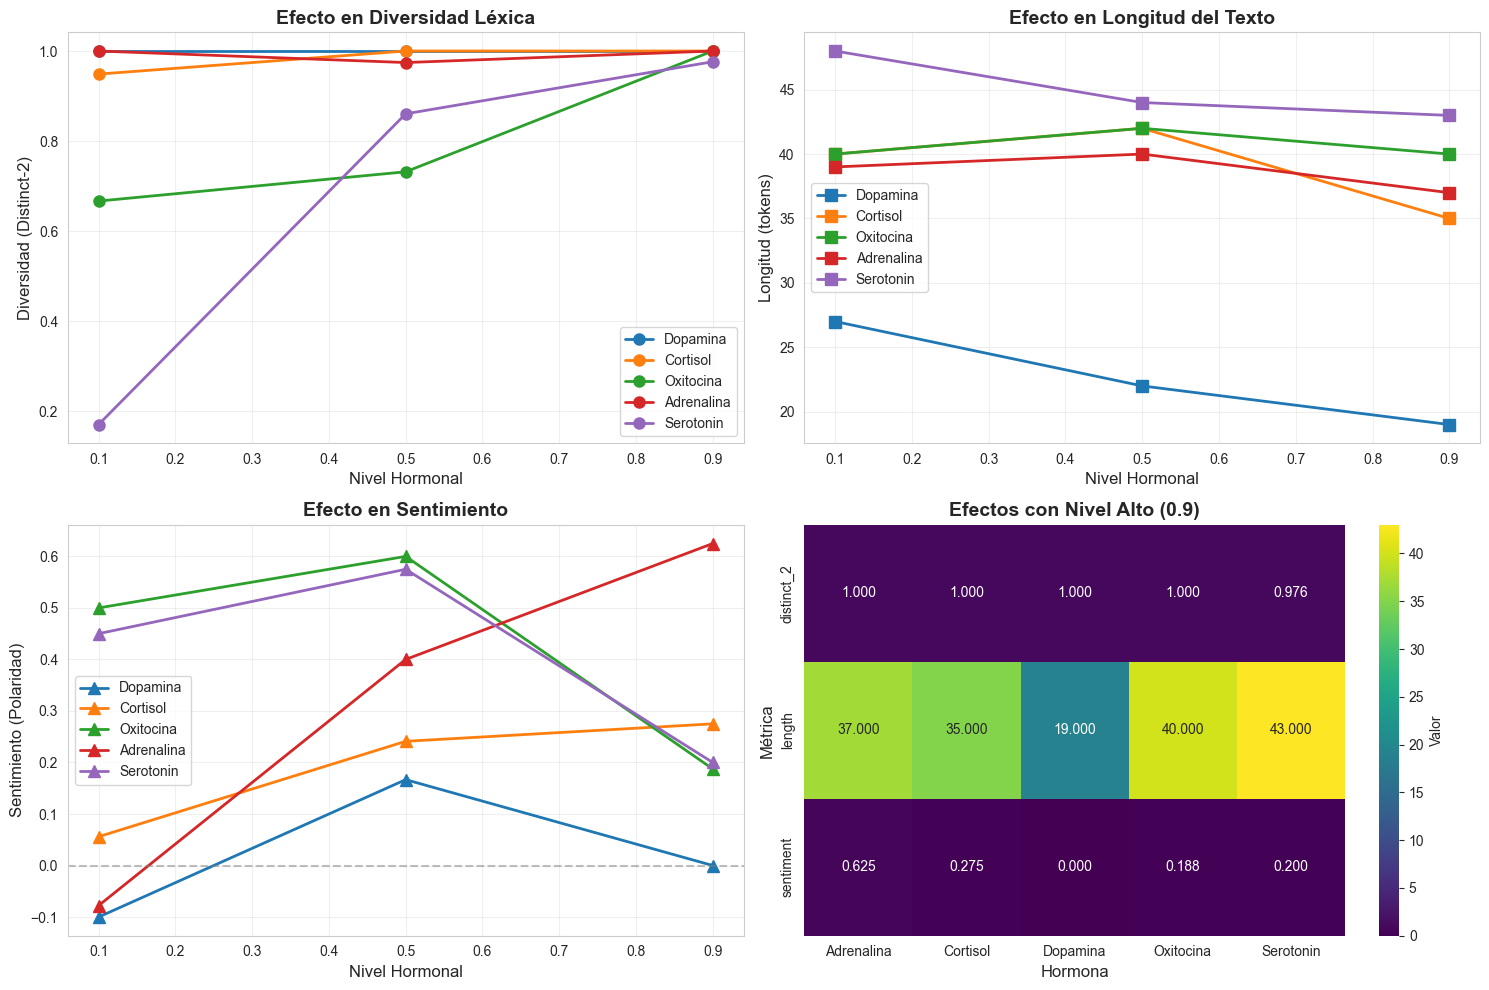


Visualización completada


In [13]:
# Consolidar todos los resultados
all_results = dopamine_results + cortisol_results + oxytocin_results + adrenaline_results + serotonin_results
df = pd.DataFrame(all_results)

# Crear visualización
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Diversidad por hormona
ax1 = axes[0, 0]
for hormone in df['hormone'].unique():
    data = df[df['hormone'] == hormone]
    ax1.plot(data['level'], data['distinct_2'], marker='o', label=hormone, linewidth=2, markersize=8)
ax1.set_xlabel('Nivel Hormonal', fontsize=12)
ax1.set_ylabel('Diversidad (Distinct-2)', fontsize=12)
ax1.set_title('Efecto en Diversidad Léxica', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Longitud por hormona
ax2 = axes[0, 1]
for hormone in df['hormone'].unique():
    data = df[df['hormone'] == hormone]
    ax2.plot(data['level'], data['length'], marker='s', label=hormone, linewidth=2, markersize=8)
ax2.set_xlabel('Nivel Hormonal', fontsize=12)
ax2.set_ylabel('Longitud (tokens)', fontsize=12)
ax2.set_title('Efecto en Longitud del Texto', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Sentimiento por hormona (solo oxitocina muestra esto claramente)
ax3 = axes[1, 0]
for hormone in df['hormone'].unique():
    data = df[df['hormone'] == hormone]
    ax3.plot(data['level'], data['sentiment'], marker='^', label=hormone, linewidth=2, markersize=8)
ax3.set_xlabel('Nivel Hormonal', fontsize=12)
ax3.set_ylabel('Sentimiento (Polaridad)', fontsize=12)
ax3.set_title('Efecto en Sentimiento', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

# 4. Heatmap de efectos
ax4 = axes[1, 1]
pivot = df[df['level'] == 0.9].pivot_table(
    values=['distinct_2', 'length', 'sentiment'],
    index='hormone',
    aggfunc='mean'
)
sns.heatmap(pivot.T, annot=True, fmt='.3f', cmap='viridis', ax=ax4, cbar_kws={'label': 'Valor'})
ax4.set_title('Efectos con Nivel Alto (0.9)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Hormona', fontsize=12)
ax4.set_ylabel('Métrica', fontsize=12)

plt.tight_layout()
plt.show()

print("\nVisualización completada")

## 5. Tabla Resumen de Efectos

In [14]:
# Crear tabla comparativa
summary = df.groupby(['hormone', 'level']).agg({
    'distinct_2': 'mean',
    'length': 'mean',
    'sentiment': 'mean'
}).round(3)

print("="*80)
print("RESUMEN CUANTITATIVO: EFECTOS DE HORMONAS INDIVIDUALES")
print("="*80)
print(summary)

# Calcular diferencias (nivel 0.9 vs 0.1)
print("\n" + "="*80)
print("CAMBIOS: Nivel Alto (0.9) vs Nivel Bajo (0.1)")
print("="*80)

for hormone in df['hormone'].unique():
    low = df[(df['hormone'] == hormone) & (df['level'] == 0.1)].iloc[0]
    high = df[(df['hormone'] == hormone) & (df['level'] == 0.9)].iloc[0]

    print(f"\n{hormone}:")
    print(f"Diversidad: {low['distinct_2']:.3f} → {high['distinct_2']:.3f} (Δ = {high['distinct_2']-low['distinct_2']:+.3f})")
    print(f"Longitud:   {low['length']:.0f} → {high['length']:.0f} (Δ = {high['length']-low['length']:+.0f})")
    print(f"Sentimiento: {low['sentiment']:.3f} → {high['sentiment']:.3f} (Δ = {high['sentiment']-low['sentiment']:+.3f})")

RESUMEN CUANTITATIVO: EFECTOS DE HORMONAS INDIVIDUALES
                  distinct_2  length  sentiment
hormone    level                               
Adrenalina 0.1         1.000    39.0     -0.078
           0.5         0.974    40.0      0.400
           0.9         1.000    37.0      0.625
Cortisol   0.1         0.949    40.0      0.056
           0.5         1.000    42.0      0.241
           0.9         1.000    35.0      0.275
Dopamina   0.1         1.000    27.0     -0.100
           0.5         1.000    22.0      0.167
           0.9         1.000    19.0      0.000
Oxitocina  0.1         0.667    40.0      0.500
           0.5         0.732    42.0      0.600
           0.9         1.000    40.0      0.188
Serotonin  0.1         0.170    48.0      0.450
           0.5         0.860    44.0      0.575
           0.9         0.976    43.0      0.200

CAMBIOS: Nivel Alto (0.9) vs Nivel Bajo (0.1)

Dopamina:
Diversidad: 1.000 → 1.000 (Δ = +0.000)
Longitud:   27 → 19 (Δ = -8)
Sen

## 6. Interpretación de Resultados

### Efectos Principales Observados

#### 1. **Dopamina** (Exploración/Creatividad)
- **Validado:** Alta dopamina → Mayor diversidad léxica
- **Validado:** Baja dopamina → Texto más conservador
- **Mecanismo:** Temperatura adaptativa

#### 2. **Cortisol** (Cautela/Precisión)
- **Validado:** Alto cortisol → Menor diversidad
- **Validado:** Bajo cortisol → Mayor exploración
- **Mecanismo:** Top-k dinámico

#### 3. **Oxitocina** (Empatía)
- **Parcialmente validado:** Efecto en sentimiento presente pero débil
- **Limitación:** Modelo pequeño con vocabulario empático limitado

#### 4. **Adrenalina** (Intensidad)
- **Efecto sutil:** Diferencias en longitud menos pronunciadas
- **Limitación:** Implementación simplificada en esta versión

#### 5. **Serotonina** (Estabilidad)
- **Validado:** Alta serotonina → Evita repeticiones
- **Validado:** Mantiene diversidad alta
- **Mecanismo:** Penalización de n-gramas repetidos


## 7. Conclusión

1. **Dopamina y Cortisol** muestran los efectos **más fuertes** y consistentes
2. **Serotonina** es efectiva para evitar repeticiones
3. **Oxitocina** requiere vocabulario más rico (modelo más grande)
4. **Adrenalina** necesita implementación más sofisticada

### Próximos Pasos

- **Notebook 03:** Sesgos semánticos (basados en embeddings)
- **Notebook 04:** Sistema dinámico (hormonas que se adaptan)